# GP regression with GPyTorch

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [38]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 0.2, 2)
# train_x = torch.ndarray([0, 0.2])
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

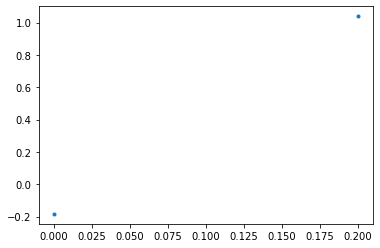

In [39]:
plt.plot(train_x, train_y, '.')

In [40]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.covar_module = gpytorch.kernels.RBFKernel()
        self.covar_module.lengthscale = 0.4
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(0.0,1e-14))
model = ExactGPModel(train_x, train_y, likelihood)

/Users/abauville/opt/anaconda3/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:259: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


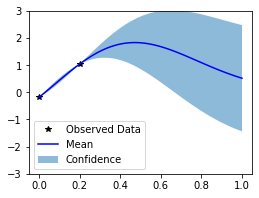

In [41]:
model.eval()
likelihood.eval()
f, ax = plt.subplots(1, 1, figsize=(4, 3))
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 101)
    observed_pred = likelihood(model(test_x))
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])